## IMDb Revised
Hey Here's my revised notebook, the runs you see are from my UBUNTU Linux 16.04 LTS box running a core I7-7800X box with a GTX1080 cuda and 64GB of RAM, the disk is a Samsung 850-EVO.  I've modified this just a bit so you should be able to run it straigtt thru. I tried to document it as per Jeremy's discussion, please respond to @interogativ if I got something wrong.

In [1]:
from fastai.text import *
import html

In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/aclImdb/')

## Standardize format

CLAS_PATH - classification model path, LM_PATH - language model path
classification will be used to create a sentiment analaysis model
language model will be used to predict the next word model

In [3]:
CLAS_PATH=Path('data/imdb_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

In [4]:
CLASSES = ['neg', 'pos', 'unsup']

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r').read())
            labels.append(idx)
    return np.array(texts),np.array(labels)

trn_texts,trn_labels = get_texts(PATH/'train')
val_texts,val_labels = get_texts(PATH/'test')

there are 75K texts but only 50K are classified, 25K positive, 25K negative

In [5]:
len(trn_texts),len(val_texts)

(75000, 25000)

In [6]:
col_names = ['labels','text']

change indices to random order from 1 - n

In [7]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [8]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

create training set as CSV with labels first (col1), document text (col2) as semi-standard format

In [9]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

## select only labels that are not 2 from sentiment analysis (CLAS_PATH) (classifcation path) because 2 means the training was unsupervised.

In [10]:
df_trn[df_trn['labels']!=2].to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

In [11]:
df_trn.head()

,labels,text
0,2,I saw that film when i studied films in englan...
1,0,"1) I am not weapon expert, but even i can see ..."
2,1,Wow. A truly fantastic 'trip' movie that has t...
3,2,While this was the Abbott & Costello's second ...
4,2,Freaky Fairy tales just doesn't work as a film...


In [12]:
(CLAS_PATH/'classes.txt').open('r').readlines()


['neg\n', 'pos\n', 'unsup\n']

sklearn.model_selection.train_test_split is a handy function tat takes our two text sets (training and validation) and splits off the test_size(10%) to create training and validation set of 90%/10% respectively, so that we have 90K training and 10K test

In [13]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts,val_texts]), test_size=0.1)

In [14]:
len(trn_texts), len(val_texts)

(90000, 10000)

for language model, there are no classes, so just init labels to zero, so that our CSV files are in a consistent format

In [15]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

In [16]:
df_trn.head()

,labels,text
0,0,A disgrace trying to be a mirror of the L.A.P....
1,0,I saw this movie at 2 AM late one night in 199...
2,0,This is a great ending to the show. The fact t...
3,0,Loosely based on the James J Corbett biography...
4,0,John Waters early work (until Polyester) made ...


## Language model tokens

In [17]:
chunksize=24000

fixup() will clean up our text and remove stuff we don't care about.  first it replaces some standard MIME encodings with their text equivalents, then using a regular expression replaces multiple spaces with space, thn it unescapes HTML sequences.

In [18]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

get_texts() 
first converts labels to ints, then for each text it puts {BOS} ('xbos' from above) which means beginning of string at the start of a new text file. similarly if the text has multiple fields (presumably each field in it's own column of the CSV file) we label the start of each field with 'xfld N' where n is the column (field index).
next it tokenizes the texts using Tokenizer().proc_all_mp() to spread the tokenization task amoung the processor cores. The partition_by_cores() splits the text into a list of N texts where N is the number of cores.

In [19]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)
    text_per_core_list = partition_by_cores(texts)
    print('Split text into {} Lists'.format(len(text_per_core_list)))
    tok = Tokenizer().proc_all_mp(text_per_core_list)
    return tok, list(labels)

In [20]:
import multiprocessing
print('My Machine has {} cores'.format(multiprocessing.cpu_count()))

My Machine has 12 cores


get_all() is a drop in replacement for get_texts that uses the iterator we will create below, to iterate through all of the "chunks" of the data frame.  It call get_texts for us but does the iteration

In [21]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print('processing chunk {}'.format(i))
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

using chunksize will cause pandas to return a dataframe iterator instead of a dataframe, we can then use the iterator to iterate over larger datasets of words then would normally fit in memory

In [22]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [23]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

processing chunk 0
Split text into 12 Lists
processing chunk 1
Split text into 12 Lists
processing chunk 2
Split text into 12 Lists
processing chunk 3
Split text into 12 Lists
processing chunk 0
Split text into 12 Lists


In [24]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

the tokenized text has some addtional tokens added that serve to keep the sense of the text that has been converted to lower case.  The '.t_up word' token means that the word following was originally uppercase. '.tk_rep N c' means that the char c repeats N times.  '.tk_wrep N word' means that the next word repeats N times.

In [25]:
' '.join(tok_trn[0])

"\n xbos xfld 1 a disgrace trying to be a mirror of the l.a.p.d . a few aging stars coasting through a terrible script . dirty cops wanting to turn against other dirty cops . cops that do n't want to be cops . unrealistic , over - kill on the gun fire . front line cast is made up of : dennis hopper , michael madsen , marc singer and charles durning . a glimmer of promise from kiara hunter , carolyn dunn and brenda campbell . this movie can serve as background noise while passing around the party dip and refilling the cold refreshments . i guess there is no law for bad acting . even the simulated sex is terrible ."

In [26]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [27]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

now that we have tokens we must 'numericalize' it, here we make a list of all the tokens that appear (vocabulary) and then replace each token with a number.  But our first step is find the frequency of each token, so that we can get rid of ones we don't care about and we can limit our vocabulary to about 60,000 of the most frequent tokens.

In [28]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 1209682),
 ('.', 991891),
 (',', 986525),
 ('and', 587494),
 ('a', 583282),
 ('of', 525360),
 ('to', 485220),
 ('is', 393598),
 ('it', 341763),
 ('in', 337531),
 ('i', 307847),
 ('this', 270592),
 ('that', 261246),
 ('"', 237116),
 ("'s", 221597),
 ('-', 187685),
 ('was', 180666),
 ('\n\n', 178909),
 ('as', 165958),
 ('with', 159324),
 ('for', 158747),
 ('movie', 157884),
 ('but', 150464),
 ('film', 144375),
 ('you', 124174)]

limit our numericalized tokens to the 60,000 most frequent and get rid of any unique tokens (that don't appear more than twice).

In [29]:
max_vocab = 60000
min_freq = 2

itos will be our index to token list where the index of the list maps to the token.
create list of max_vocab tokens add two tokens to the start of the list  _pad_ for padding and _unk_ for unknown.

In [30]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [31]:
itos[:5]

['_unk_', '_pad_', 'the', '.', ',']

stoi is the string to index dict, but because we have only the 60K most frequent tokens, we may come across a token that's not in our vocabulary, so defaultdict['badtoken']  return those to zero, which conveniently maps to _unk_.

In [33]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [33]:
ct = 0
for x in stoi: 
    if ct < 5: print(x,stoi[x]); ct = ct+1

_unk_ 0
_pad_ 1
the 2
. 3
, 4


In [87]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [88]:
trn_lm[0][:5]

[40, 41, 42, 39, 13]

this is how we can save our language model and the dictionary we need to decode it

In [90]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [91]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [92]:
vs=len(itos)
vs,len(trn_lm)

(60002, 90000)

## wikitext103 conversion

Wikitext103 is a pre-trained language model on the larger articles in wikipedia. Below is Jermy's pretrained LM

In [6]:
# ! wget -nH -r -np http://files.fast.ai/models/wt103/

embedding size(em_sz), number of hidden layers(nh), number of layers(nl) in our model MUST match the wikiText103 model

In [93]:
em_sz,nh,nl = 400,1150,3

PRE_PATH - pretrained path, PRE_LM_PATH - pretrained language model path

In [96]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

get the weights from our pre-trained model (../fwd_wt103).  Creates dict of name of layer, tensor of weights

In [97]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [108]:
ct = 0
for x in wgts: 
    if ct < 5: print(x); ct = ct+1

0.encoder.weight
0.encoder_with_dropout.embed.weight
0.rnns.0.module.weight_ih_l0
0.rnns.0.module.bias_ih_l0
0.rnns.0.module.bias_hh_l0


fetch the encoder weights (enc_wgts) for each token in the model, as well as the row mean (row_m); average weight acoss all elements of encoder weights

In [109]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

## map our numericalized vocabulary weights to the wikitext103 numericalized vocabulary weights

itos2 and stoi2 are the wikitext103 equivalents to our itos and stoi. We can use these to create a map.  If we find an entry in ours that's not in the wikitext dict then we'll map it to -1

In [110]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

our new weights (new_w) is equal to vocab size (vs) by embedding size (em_sz).   for every word in our itos, see if it exists in the wikitext103 stoi, if so (!= -1) then set the weight for that word to the weight stored for wikitext103.

In [111]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

now replace our old encoder weights with our new weight matrix. And since we've tied our encoder weights to our decoder weights we'll replace our decoder weights as well,  Jeremy didn't explain why we copy the new weights to the encoder with dropout weights.

In [112]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language model

In [116]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

we're going to concatentate all of our text into the training and validation dataloaders for our language model.  We're going to predict; what's the next word after these words

In [117]:
t = len(np.concatenate(trn_lm))
t,t//64

(25003010, 390672)

In [118]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

array of dropouts ratios that have been fine tuned, but if you have less data then you'll need more dropout and if you have more data you need less dropout. So just change the multiplier (0.7). If you're overfitting then increase the mupltipler, if you're underfitting, decrease the multiplier.

In [119]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

Jeremy contends that we should measure accuracy when evaluating the performance of a language model wrather than just cross entorpy loss. Or more specifically e^CE which the NLP community calls "perplexity."  CE loss penalizes models that doesn't say that it's certain about its predictions.  Accuracy just measures if we're right about the next word. But accuracy should NOT bec used as a loss function.


In [120]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.unfreeze()

In [121]:
learner.model.load_state_dict(wgts)

In [122]:
lr=1e-3
lrs = lr

learn for one epoch on the last layer (embedding weights) because these are what we changed when we created the model, so they'll be the most wrong.

In [123]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      4.396708   4.183162   0.285052  



[4.183162, 0.2850521344554986]

In [124]:
learner.save('lm_last_ft')

In [26]:
learner.load('lm_last_ft')

In [125]:
learner.unfreeze()

In [126]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      4.766887   4.587869   0.246657  



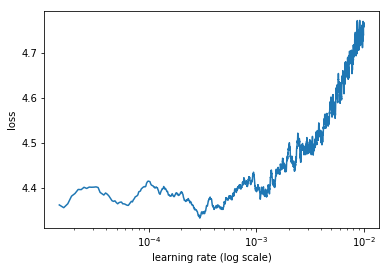

In [127]:
learner.sched.plot()

In [128]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      4.334205   4.129024   0.289507  
    1      4.246082   4.077118   0.293723                     
    2      4.178073   4.035942   0.29776                      
    3      4.134362   4.011351   0.300236                     
    4      4.099117   3.993332   0.302115                     
    5      4.065007   3.980048   0.303574                     
    6      4.078283   3.967805   0.304814                     
    7      4.085579   3.957338   0.305906                     
    8      3.998948   3.951891   0.307192                     
    9      3.982543   3.943395   0.307965                     
    10     3.959797   3.938342   0.308753                     
    11     3.963868   3.931682   0.309452                     
    12     3.929459   3.928164   0.310123                     
    13     3.981137   3.919783   0.31095                      
    14     3.959294   3.918242   0.311344                     



[3.918242, 0.311344064343038]

learner.save() save the whold language model.  learner.save_encoder() saves all BUT the last linear layer.  This allows us to use the same encoder for the classifier as we used in the language model.

In [129]:
learner.save('lm1')

In [130]:
learner.save_encoder('lm1_enc')

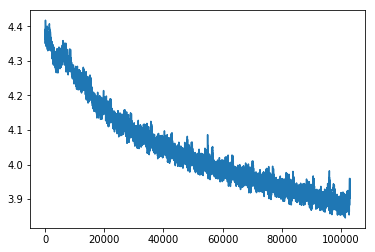

In [131]:
learner.sched.plot_loss()

## Classifier tokens

In [34]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [35]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

processing chunk 0
Split text into 12 Lists
processing chunk 1
Split text into 12 Lists
processing chunk 0
Split text into 12 Lists
processing chunk 1
Split text into 12 Lists


In [35]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [36]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [37]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [38]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [39]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

In [39]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [40]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

set back prop thru time to 70, others the same as the language model
FORCED to change bs to 16, ran out of GPU

In [41]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
#bs = 48
bs = 16

In [42]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

Create training and validation Dataloaders passing in sampler classes. Instead of shuffling the data to randomize the batches, the training sampler uses a "Sortish" sort by document lenth. The validation sampler just sorts the set by document length, with the shortest documents first.

In [43]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [44]:
# part 1
#dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [45]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

create rnn classifier with a custom head that includes two additional hidden layers one which takes an input of embedding size * 3 and outputs 50, the second of which outputs the catagory count +1. The new Hidden layer dropouts are dps[4] (see above) and .1 respectively.  The AWD LSTM dropouts follow.  

In [46]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [47]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [48]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

use descriminative learning rates (note this used to be called differential learning rates)

In [49]:
lr=3e-3
#lrm = 2.6
#lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [50]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [51]:
wd = 1e-7
#wd = 0
#learn.load_encoder('lm2_enc')
learn.load_encoder('lm1_enc')

In [53]:
learn.freeze_to(-1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 71%|███████▏  | 2230/3125 [06:57<02:47,  5.34it/s, loss=1.11] 

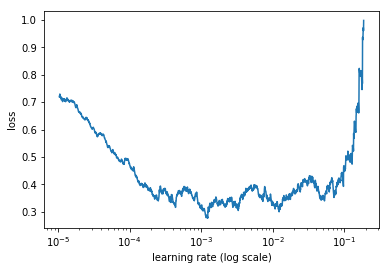

In [54]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [55]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  2%|▏         | 49/3125 [00:08<08:32,  6.00it/s, loss=0.448] 


Exception in thread Thread-13:
Traceback (most recent call last):
  File "/home/bart/anaconda2/envs/fastai1/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bart/anaconda2/envs/fastai1/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bart/anaconda2/envs/fastai1/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.300744   0.218485   0.925744  



[0.21848512, 0.9257437619961613]

In [56]:
learn.save('clas_bs16_1')

In [57]:
learn.load('clas_bs16_1')

In [58]:
learn.freeze_to(-2)

In [59]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.281986   0.191343   0.932502  



[0.19134289, 0.9325015994881638]

In [60]:
learn.save('clas_bs16_2')

In [61]:
learn.load('clas_bs16_2')

In [62]:
learn.unfreeze()

In [63]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.278926   0.196682   0.939539  
    1      0.247342   4.878974   0.935261                      
    2      0.243734   0.170975   0.940019                      
    3      0.222574   0.160491   0.944418                      
    4      0.183228   0.158154   0.945737                       
    5      0.154078   0.157707   0.944298                       
    6      0.117611   0.166843   0.944858                       
    7      0.10141    0.176083   0.945457                       
    8      0.071837   0.1898     0.943058                       
    9      0.076208   0.185309   0.942858                       
    10     0.066289   0.200921   0.942978                       
    11     0.077387   0.187123   0.943058                       
    12     0.034379   0.20557    0.942498                       
    13     0.029231   0.198277   0.942778                       



[0.19827692, 0.942778310940499]

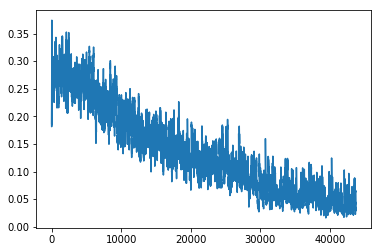

In [64]:
learn.sched.plot_loss()

In [65]:
learn.save('clas_bs16_3')

The previous state of the art result was 94.1% accuracy (5.9% error). With bidir we get 95.4% accuracy (4.6% error).

## Fin

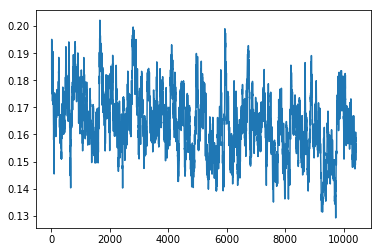

In [25]:
learn.sched.plot_loss()